# Read in the data

In [87]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [88]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [89]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [90]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [91]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [92]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [93]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [94]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [95]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


# Plotting survey correlations

In [96]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

In [97]:
sat_survey_corr = combined.corr()
sat_survey_corr = sat_survey_corr.loc[survey_fields, :]
sat_survey_corr

,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,CSD,NUMBER OF STUDENTS / SEATS FILLED,...,grade_span_max,expgrade_span_max,zip,total_students,number_programs,priority08,priority09,priority10,lat,lon
rr_s,0.230535,0.206058,0.249670,0.232199,0.059902,0.069768,0.067692,-0.125546,-0.025617,-0.081001,...,NaN,NaN,-0.103092,-0.082720,-0.171406,NaN,NaN,NaN,0.050591,-0.098253
rr_t,-0.031378,-0.010484,-0.028465,-0.023386,-0.008269,-0.016841,-0.018458,-0.026385,0.019645,-0.041974,...,NaN,NaN,-0.024091,-0.046634,-0.050622,NaN,NaN,NaN,-0.092756,-0.055198
rr_p,0.034665,0.051688,0.054048,0.047925,-0.013702,0.000027,0.035329,-0.188603,-0.031448,-0.191458,...,NaN,NaN,-0.099928,-0.169844,-0.227069,NaN,NaN,NaN,0.122586,0.017444
N_s,0.384723,0.471527,0.385180,0.423463,0.692322,0.661808,0.502398,0.892195,0.244212,0.935351,...,NaN,NaN,0.129550,0.942661,0.586136,NaN,NaN,NaN,-0.171325,-0.066135
N_t,0.254049,0.350594,0.247033,0.291463,0.560139,0.515464,0.338181,0.909168,0.269299,0.906038,...,NaN,NaN,0.158897,0.923733,0.667619,NaN,NaN,NaN,-0.184858,-0.046901
N_p,0.383032,0.464210,0.389013,0.421530,0.680333,0.657976,0.533714,0.728939,0.205329,0.785678,...,NaN,NaN,0.104068,0.817987,0.432957,NaN,NaN,NaN,-0.149107,-0.065858
saf_p_11,0.106216,0.118931,0.136731,0.122913,-0.079412,-0.064320,-0.010488,-0.363143,-0.196415,-0.342306,...,NaN,NaN,-0.188698,-0.290301,-0.358813,NaN,NaN,NaN,0.240957,-0.059055
com_p_11,-0.123188,-0.121054,-0.094316,-0.115073,-0.162610,-0.145548,-0.070715,-0.368474,-0.107558,-0.384702,...,NaN,NaN,-0.077146,-0.360806,-0.348528,NaN,NaN,NaN,0.207534,0.018565
eng_p_11,0.016373,0.005330,0.039251,0.020254,-0.043140,-0.034138,0.011983,-0.231506,-0.049386,-0.232505,...,NaN,NaN,-0.037859,-0.194448,-0.236977,NaN,NaN,NaN,0.147215,-0.012808
aca_p_11,0.024355,0.024334,0.055559,0.035155,-0.091459,-0.081141,-0.026855,-0.311564,-0.093648,-0.309984,...,NaN,NaN,-0.076421,-0.267526,-0.315592,NaN,NaN,NaN,0.162478,-0.012851


In [98]:
import matplotlib.pyplot as plt 
%matplotlib inline

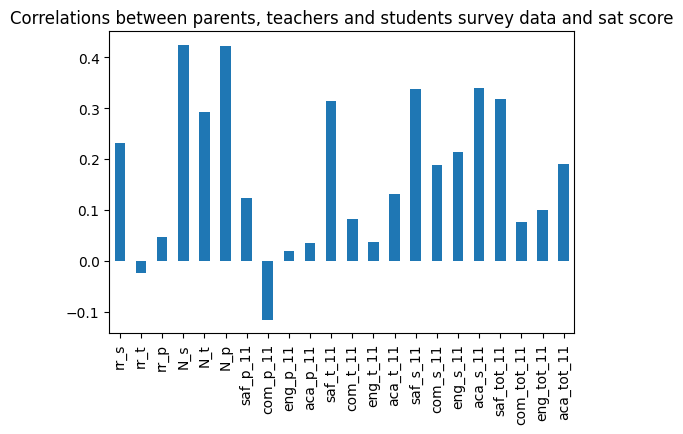

In [99]:
sat_survey_corr = combined.corr()
sat_survey_corr=sat_survey_corr.loc[survey_fields,'sat_score']
sat_survey_corr.plot.bar(title='Correlations between parents, teachers and students survey data and sat score')
plt.show()

We note that the safety score from teachers(saf_t_11) and students (saf_s_11) correlate highly with sat scores, and so did academic excpetations from students (aca_s_11) . It is surprising to see that the communication score from parents (com_p_11) has a negative correlation coefficient, however it is very weak.

# Exploring Safety and SAT Scores
## Investigate safety scores

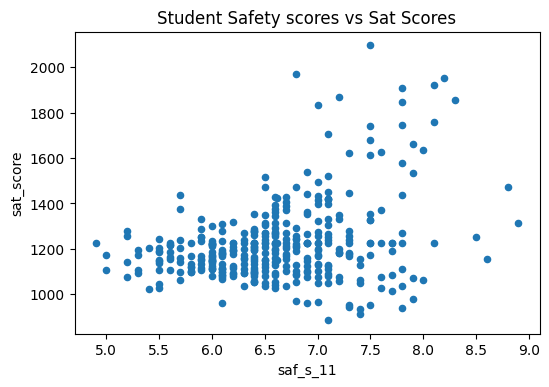

In [100]:
combined.plot.scatter(x= 'saf_s_11', y = 'sat_score', title = 'Student Safety scores vs Sat Scores')
plt.show()

At student safety scores below 7.0, the sat_scores remains somewhat constant. Most scores are within the range 1000 - 1400. After a safety score of 7.0, we do not see any clear correlation with sat scores.

## Compute the average safety score for each borough

In [101]:
import numpy as np
sat_borough = combined.groupby('boro').agg(numpy.mean)
sat_borough = sat_borough[['sat_score','saf_t_11', 'saf_p_11']]
sat_borough

,sat_score,saf_t_11,saf_p_11
boro,,,
Bronx,1157.598203,7.026882,8.346237
Brooklyn,1181.364461,6.985849,8.036792
Manhattan,1278.331410,7.287778,8.288889
Queens,1286.753032,7.365625,8.098437
Staten Island,1382.500000,7.210000,7.800000


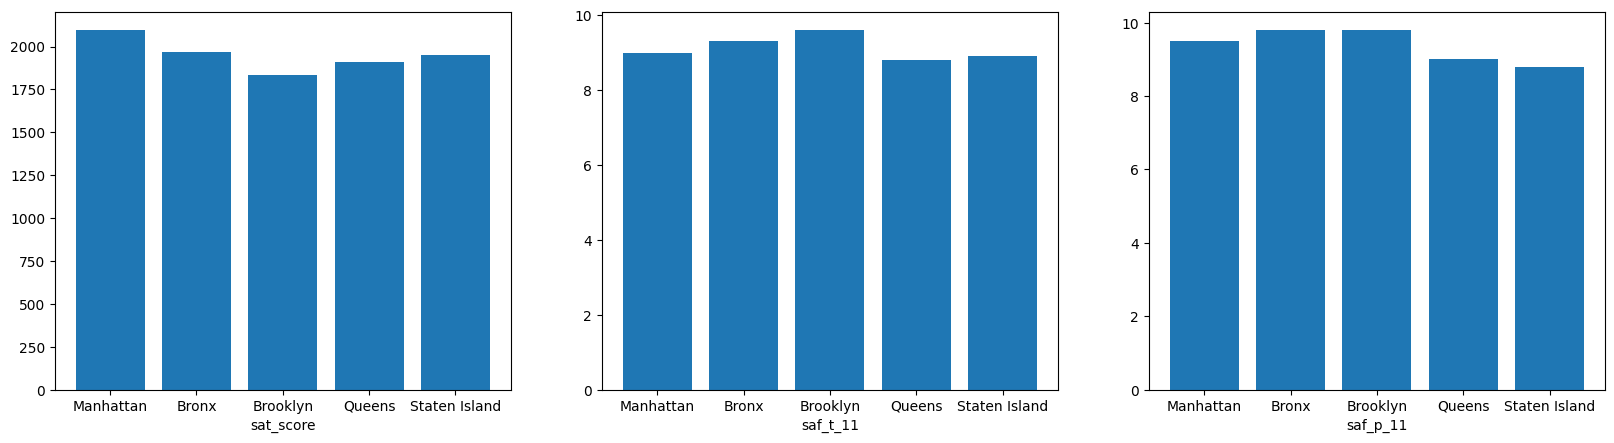

In [102]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize = (20,5))

#ax.legend().set_visible(False)
ax1.bar(combined['boro'],combined['sat_score'])
ax1.set_xlabel('sat_score')

ax2.bar(combined['boro'],combined['saf_t_11'])
ax2.set_xlabel('saf_t_11')

ax3.bar(combined['boro'],combined['saf_p_11'])
ax3.set_xlabel('saf_p_11')

plt.show()

It looks like Manhattan and Queens tend to have lower safety scores, whereas Brooklyn has higher safety scores. It is interesting to note that the average SAT score for Brooklyn is lower than low safety areas. We cannot however conclude SAT score comparision between Boros based on safety scores. Hence we will focus on other factors

# Exploring Race and SAT Scores
## Investigate racial differences in SAT scores.

In [103]:
sat_survey_corr = combined.corr()
race_corr = sat_survey_corr[['white_per', 'asian_per', 'black_per', 'hispanic_per', 'sat_score']]
race_corr = race_corr.loc[['white_per', 'asian_per', 'black_per', 'hispanic_per']]
# race_corr = race_corr.loc[['white_per', 'asian_per', 'black_per', 'hispanic_per'],'sat_score']
race_corr


,white_per,asian_per,black_per,hispanic_per,sat_score
white_per,1.000000,0.349557,-0.410717,-0.344970,0.620718
asian_per,0.349557,1.000000,-0.417373,-0.353186,0.570730
black_per,-0.410717,-0.417373,1.000000,-0.566739,-0.284139
hispanic_per,-0.344970,-0.353186,-0.566739,1.000000,-0.396985


In [104]:
race_corr_sat = race_corr['sat_score']
race_corr_sat


white_per       0.620718
asian_per       0.570730
black_per      -0.284139
hispanic_per   -0.396985
Name: sat_score, dtype: float64

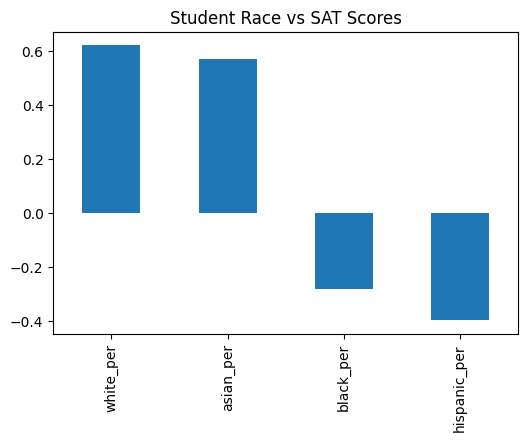

In [105]:
race_corr_sat.plot.bar(title = 'Student Race vs SAT Scores')
plt.show()

The bar plot shows us that white and asian students are more likely to perform better on the sat than black and hispanics. This was expected as black and hispanic communities are more prone to come from an emporvrished background not enabling to hire tutors or sometimes need to work outside of school to support their family.

## Explore schools with low SAT scores and high values for hispanic_per

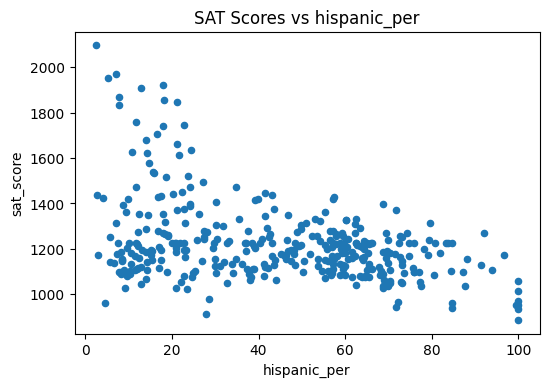

In [106]:
combined.plot.scatter('hispanic_per','sat_score',title = 'SAT Scores vs hispanic_per')
plt.show()

We notice from the plot above that low sat scores correlate with high percentage of hispanic students. This supports the correlation coefficient of -0.4 calculated when exploring each student race and average sat_scores

## Research any schools with a hispanic_per greater than 95%

In [107]:
school_name= combined[combined['hispanic_per']>95]['SCHOOL NAME']

In [108]:
school_name

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

## Research any schools with a hispanic_per less than 10% and an average SAT score greater than 1800

In [109]:
# combined.groupby('sat_score')
school_sat_per = combined[(combined['hispanic_per']<10) & (combined['sat_score']>1800)]
school_name = school_sat_per[['SCHOOL NAME','hispanic_per','sat_score']]
school_name                      

,SCHOOL NAME,hispanic_per,sat_score
37,STUYVESANT HIGH SCHOOL,2.4,2096.0
151,BRONX HIGH SCHOOL OF SCIENCE,7.2,1969.0
187,BROOKLYN TECHNICAL HIGH SCHOOL,7.9,1833.0
327,QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...,7.9,1868.0
356,STATEN ISLAND TECHNICAL HIGH SCHOOL,5.3,1953.0


The schools with low hispanic proportions and high SAT schools are Elite High Schools and also focused on Technical Education. Though this may not explain the relation between Hispanic proportion and score but their high scores could be explained by the fact that they have an entrance based admission and have students who already did well in a standardized test.

# Exploring Gender and SAT Scores
## Investigate gender differences in SAT scores

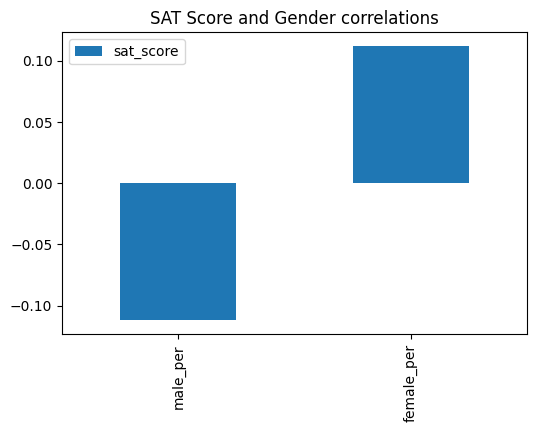

In [110]:
fe_ma = combined[['male_per','female_per','sat_score']].corr()
fe_ma_sat = fe_ma.loc[['male_per','female_per'],['sat_score']]
# fe_ma_sat
fe_ma_sat.plot.bar(title = 'SAT Score and Gender correlations')
plt.show()

The bar pot above shows us that the percentage of female students has a positive correlation with higher sat scores, whereas the percentage of male students in negatively correlated, meaning that more male students has lower sat scores

## Investigate schools with high SAT scores and a high female_per

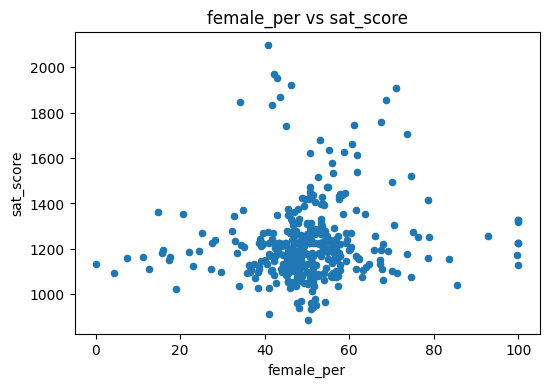

In [111]:
combined.plot.scatter('female_per','sat_score', title = 'female_per vs sat_score')
plt.show()

Based on the scatter plot, there doesn't seem to be any real correlation between sat_score and female_per. (A value of .11 was lower than the conventional threshold of 0.3 to begin with)
However, there is a cluster of schools with a high percentage of females (60 to 80) and high SAT scores.

## Research any schools with a female_per greater than 60% and an average SAT score greater than 1700.


In [112]:
school_name = combined[(combined['female_per']>60) & (combined['sat_score']>1700)][['SCHOOL NAME','female_per','sat_score']]
school_name

,SCHOOL NAME,female_per,sat_score
5,BARD HIGH SCHOOL EARLY COLLEGE,68.7,1856.0
26,ELEANOR ROOSEVELT HIGH SCHOOL,67.5,1758.0
60,BEACON HIGH SCHOOL,61.0,1744.0
61,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,73.6,1707.0
302,TOWNSEND HARRIS HIGH SCHOOL,71.1,1910.0


These schools seem to be very selective high schools with a focus on preparing students for college entrances.

# Exploring AP Scores vs. SAT Scores

In [120]:
combined['ap_per'] = combined['AP Test Takers ']/combined['total_enrollment']

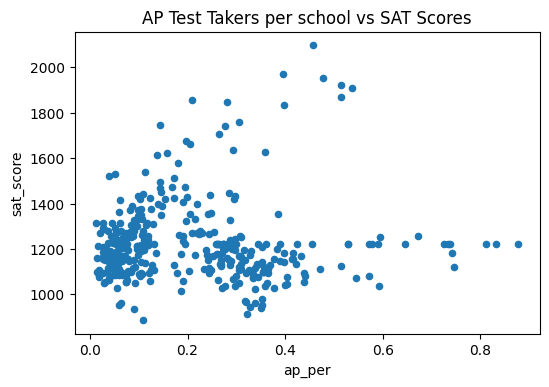

In [121]:
combined.plot.scatter('ap_per','sat_score',title='AP Test Takers per school vs SAT Scores')
plt.show()
                      

In [122]:
### Checking the actual correlation value

ap_per_sat_score_corr = combined.corr()['sat_score'].loc['ap_per']
print(ap_per_sat_score_corr)

0.05717081390766967


The AP Test takers percentage vs SAT scores scatter plot shows that the majority of data points are in the lower ranges. There is no clear correlation, after ap_per of 0.2, a portion of schools see an increase in SAT scores with increased number of AP test takers, however, the majority of remaining data points remain somewhat constant

# Conclusions:

- The following are indicators of high SAT scores:
    * Safety scores by Students
    * Saftey scores by Teachers
    * Racial Proportions - White / Asian could indicate high SAT scores, while Black/Hispanic would indicate low SAT scores
    * Gender is not a very strong indicator
    * The exceptions to the Racial Proportion indicators or Gender indicators are schools with high technical focus or with an admission criteria that involves a difficult standardized test.  